# CPA example V$_x$Bi$_{2-x}$Te$_3$ (x=5%)

Try CPA for alloying of Bi$_2$Te$_3$ topological insulator:

1. change from use of Lloyd's formula to average renormalized energy weights (Lloyd does not work together with CPA)
2. set up CPA structure for V doped Bi$_2$Te$_3$
3. run auxiliary voronoi step to have V starting potential embedded into Bi$_2$Te$_3$
4. construct CPA starting potential from converged Bi$_2$Te$_3$ potenital and Voronoi potential of V atoms
5. run CPA self consistency
6. run CPA DOS and band structure and compare to clean Bi$_2$Te$_3$

Note that the converged potential for a vertain concentration (here 5%) can be used a a starting point for other concentrations.

**Attention: The KKR-BdG version of the host code needs to be used since this is the only branch that has the renormalization factor.**

# Qustion:
- How to calculate the concentration
    $\frac{\# impurity\ atom\ number}{\#Total\ atoms\ in\ impurity\ cluster} *100%$


   Sol: Concentration (x) of different atoms (V$_{x}$Bi$_{2-x}$) form at one position and is expressd as 0.95Bi0.05V.
   
- Such kind of idea how create a nucleus and stomic cell, so how to create also the potential.
- Soes 'Xinipol' reperesent the percentage of the magnetic field set in 'HFIELD' 

In [9]:
%load_ext autoreload
%autoreload 2

from aiida import load_profile
profile = load_profile()

import os
import numpy as np
import math as m
import pymatgen
import scipy.constants as cons
import matplotlib.pyplot as plt
from aiida.orm import load_node, Code, load_group, Group, WorkChainNode, Dict, StructureData
from aiida.engine import submit
from aiida_kkr.tools import find_parent_structure, plot_kkr, kkrparams, neworder_potential_wf
from aiida_kkr.calculations import KkrCalculation, VoronoiCalculation
from aiida_kkr.workflows import kkr_dos_wc, kkr_bs_wc, kkr_scf_wc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# global settings

# code and options for BdG code on Claix
# BdG code is needed to have weight renormalization feature
kkr_code = Code.get_from_string('kkr_BdG@claix18_init')
options = {
    'max_wallclock_seconds': 2*36000, # 20h max runtine
    'resources': {'tot_num_mpiprocs': 40*2, 'num_machines': 2}, # only 40 ranks to divide by 10 atoms per unit cell
    # use correct project in accounting (SBATCH needs to be first in list of custom scheduler commands):
    'custom_scheduler_commands': '#SBATCH --account=jara0191\n\nulimit -s unlimited; export OMP_STACKSIZE=2g', # make sure stacksize is large
    'withmpi': True
}

## run simplify energy integration to mimick use of Lloyd's formula

later on skip this and just import the proper KkrCalculation node as starting point

In [11]:
scf_lly = load_node('23b13d9d-6e02-46c7-b3ac-17033b205b19')
struc0 = find_parent_structure(scf_lly)
    

In [12]:
# change parameters to use renormalization factor instead of Lloyd's formula

# extract old parameters
params = kkrparams(**{k:v for k,v in scf_lly.inputs.parameters.get_dict().items() if v is not None and k!='use_input_alat'})
params.set_value('use_input_alat', True)

# find average renormalization factor for weights
with scf_lly.outputs.retrieved.open('output.000.txt') as _f:
    txt = _f.readlines()
    rfac = [i for i in txt if 'RENORM_LLY: Renormalization factor of total charge' in i]
    rfac = float(rfac[0].split()[-1])
    
# now update parameters
params.set_multiple_values(
    RUNOPT = ['NEWSOSOL'], # remove Lloyd
    WFAC_RENORM = rfac
)

In [13]:
# run scf with average renormalized weights
builder = KkrCalculation.get_builder()
builder.code = kkr_code
builder.metadata.label = 'Bi2Te3_renormalized_e_weights'
builder.metadata.options = options
builder.parameters = Dict(dict=params)
builder.parent_folder = scf_lly.outputs.remote_folder
# scf_renorm = submit(builder)
scf_renorm = load_node('7d9bf737-f66a-4cd9-b6cf-282bd6d0277c')
#plot_kkr(scf_renorm, silent=False)

## compare DOS with Lloyd and with average renormalized weights

In [14]:
# Lloyd DOS

builder = kkr_dos_wc.get_builder()
wfd = kkr_dos_wc.get_wf_defaults()
wfd['emin'] = -3.
wfd['emax'] = 3.
wfd['kmesh'] = [50, 50, 50]
builder.kkr = kkr_code
builder.metadata.label = 'Bi2Te3 DOS around EF'
builder.options = Dict(dict=options)
builder.remote_data = scf_lly.outputs.remote_folder
builder.wf_parameters = Dict(dict=wfd)

# dos_ref = submit(builder)
dos_ref = load_node('fd831449-2a37-4316-91e0-656829d69f7a')

Version of workflow: 0.8.0


In [15]:
# renormalized weights

builder = dos_ref.get_builder_restart()
builder.remote_data = scf_renorm.outputs.remote_folder
builder.metadata.label = 'Bi2Te3 (renorm weights) DOS around EF'
# dos = submit(builder)
dos = load_node('b2c6edee-92f6-4681-8346-c139abc84b13')

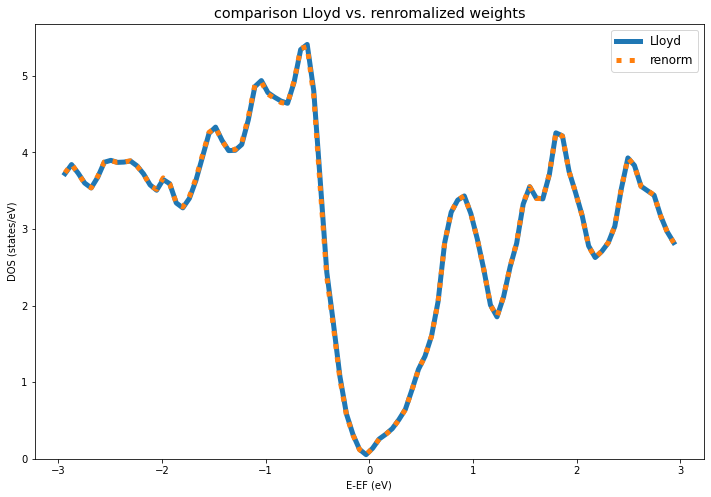

In [16]:
plt.figure(figsize=(12,8))
kwargs = dict(silent=True, sum_spins=True, l_channels=False,
              nofig=True, noshow=True, lw=5)
plot_kkr(dos_ref, label='Lloyd', **kwargs)
plot_kkr(dos, label='renorm', color='C1', ls=':', **kwargs)
plt.legend(fontsize='large')
plt.title('comparison Lloyd vs. renromalized weights', fontsize='x-large')
plt.ylim(0)
plt.show()

In [17]:
atoms= [0,1,2,3,4,5]
label= ['Te', 'Te', 'Te', 'Bi', 'Bi']
for 
    kwargs = dict(silent=True, sum_spins=True, l_channels=False,
                  nofig=True, noshow=True, lw=5)
    plot_kkr(dos_ref, label='Lloyd',atoms= True, **kwargs)

SyntaxError: invalid syntax (<ipython-input-17-f01d7367a41f>, line 3)

## compare band structures

In [18]:
# create k-points around Gamma

# from aiida.orm import KpointsData
# kpts = KpointsData()
# kpts.set_cell_from_structure(struc0)
# k = [[-0.5+0.5*i/100.,0., 0.] for i in range(100)]
# k += [[0.0, 0.5*i/100., 0.] for i in range(101)]
# kpts.set_kpoints(k, cartesian=True)
# kpts.store()
kpts = load_node('8e6447f0-2149-4475-8458-cd72de0c58ca')

In [19]:
# Lloyd band structure

builder = kkr_bs_wc.get_builder()
wfd = kkr_bs_wc.get_wf_defaults()
wfd['emin'] = -3.
wfd['emax'] = 3.
builder.kkr = dos_ref.inputs.kkr
builder.kpoints = kpts
builder.metadata.label = 'Bi2Te3 around EF'
builder.options = dos_ref.inputs.options
builder.wf_parameters = Dict(dict=wfd)
builder.remote_data = scf_lly.outputs.remote_folder

# bs_ref = submit(builder)
bs_ref = load_node('c7e2b23b-1f73-4455-8281-e8b8d489b69d')

Version of the kkr_bs_wc workflow: 0.1.1


In [20]:
# renormalized weights

builder = bs_ref.get_builder_restart()
builder.remote_data = scf_renorm.outputs.remote_folder
builder.metadata.label = 'Bi2Te3 (renorm weights) around EF'
# bs = submit(builder)
bs = load_node('35863ca9-26bd-48f8-8bdb-8c54ec172ae1')

loading data
loading data


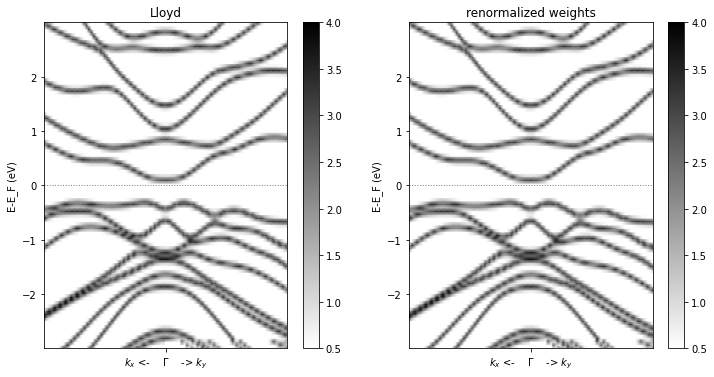

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
c = bs_ref.get_outgoing(node_class=KkrCalculation).first().node
plot_kkr(c, silent=True, noshow=True, nofig=True, cmap='binary')
plt.xticks([100], ['$k_x$ <-    $\Gamma$    -> $k_y$'])
plt.title('Lloyd'); plt.xlabel('')
plt.clim(0.5,4)

plt.subplot(1,2,2)
c = bs.get_outgoing(node_class=KkrCalculation).first().node
plot_kkr(c, silent=True, noshow=True, nofig=True, cmap='binary')
plt.xticks([100], ['$k_x$ <-    $\Gamma$    -> $k_y$'])
plt.title('renormalized weights'); plt.xlabel('')
plt.clim(0.5,4)

#plt.show()

Since bandstructure and DOS give the same solution we conclude that using renormalized weights works just as well as Lloyd

---

## prepare CPA inputs

### first CPA structure and voronoi starting potential


In [22]:
# prepare CPA structure

conc = 0.05

# struc_cpa = StructureData(cell=struc0.cell)
# pos_cpa = []
# for iatom, site in enumerate(struc0.sites):
#     if iatom not in [3,4]:
#         # put CPA sites to the end
#         struc_cpa.append_atom(
#             position=site.position,
#             symbols=site.kind_name.replace('HX', 'X')
#         )
#     else:
#         # collect positions of Bi atoms for CPA changes
#         pos_cpa.append(site.position)
# # now add CPA sites
# for pos in pos_cpa:
#     struc_cpa.append_atom(
#         position=pos,
#         symbols=['Bi', 'V'],
#         weights=[1.0-conc, conc]
#     )

# print(struc_cpa.store())
struc_cpa = load_node('445b1ced-0ed4-4e59-9917-fd8212c334dc')
struc_cpa.sites, struc_cpa.kinds

([<Site: kind name 'Te' @ 0.0,0.0,0.0>,
  <Site: kind name 'Te' @ -2.0670559458015e-16,2.5305049625927,26.78792133004>,
  <Site: kind name 'Te' @ -7.5181394577443e-17,-2.3960630364491e-17,24.023765563056>,
  <Site: kind name 'X' @ 1.8747016921119e-16,2.5305049625927,23.373375970824>,
  <Site: kind name 'X' @ -4.6526674632394e-17,1.2427329655867e-16,27.438310922272>,
  <Site: kind name 'X' @ 1.7975343758741e-16,2.5305049625927,29.470778397996>,
  <Site: kind name 'X' @ -3.8809943008617e-17,1.0071414359274e-16,21.3409084951>,
  <Site: kind name 'X' @ 2.1914815820078,1.2652524812963,25.405843446548>,
  <Site: kind name 'BiV' @ 2.1914815820078,1.2652524812963,22.357142232962>,
  <Site: kind name 'BiV' @ 2.1914815820078,1.2652524812963,28.454544660134>],
 [<Kind: name 'Te', symbol 'Te'>,
  <Kind: name 'X', symbol 'X'>,
  <Kind: name 'BiV', symbol '{Bi0.95V0.05}'>])

In [23]:
# prepare starting potential

# clear parameters
for k in ['BRAVAIS', 'NAEZ', '<RBASIS>', 'CARTESIAN',
          '<ZATOM>', 'NATYP', 'RCLUSTXY']:
    params.remove_value(k)

# run voronoi with CPA structure to get V starting potential
builder = VoronoiCalculation.get_builder()
builder.code = Code.get_from_string('voro@claix18_init')
builder.metadata.label = 'cpa_startpot_creation'

builder.metadata.options = {
    'max_wallclock_seconds': 500,
    'resources': {'tot_num_mpiprocs': 1, 'num_machines': 1},
    'withmpi': False
}

builder.parameters = Dict(dict=params)
builder.structure = struc_cpa
# voro_cpa_startpot = submit(builder)
voro_cpa_startpot = load_node('a0cabcc5-2fca-4801-b668-3d4705c092f2')

### combine voronoi startpot with converged Bi2Te3 potential for faster convergence

In [24]:

settings_dict = {
    'neworder': [0, 1, 2, 5, 6, 7, 8, 9, 3, 3, 4, 4],
    'replace_newpos': [[18, 18], [19, 19], [22, 22], [23, 23]], # V1-[[spin up], down, V1-spin up, down]
    'pot1': 'out_potential',
    'pot2': 'output.pot',
}

# startpot_cpa = neworder_potential_wf(
#     Dict(dict=settings_dict),
#     parent_calc_folder= scf_lly.outputs.remote_folder,
#     parent_calc_folder2= voro_cpa_startpot.outputs.remote_folder,
# )

startpot_cpa = load_node('d12e5cdc-fd63-4e93-b8d8-38859f92f787')
# startpot_cpa

In [25]:
# [i.split()[0:4] for i in startpot_cpa.get_content().split('\n') if 'exc' in i]

In [26]:
builder = voro_cpa_startpot.get_builder_restart()
builder.metadata.label = 'aux_for_combined_potential'
builder.potential_overwrite = startpot_cpa
# voro_cpa_startpot2 = submit(builder)
voro_cpa_startpot2 = load_node('a45f0e87-0ea3-43fe-803d-885e883b80d2')

## run CPA selfconsistency

First try manually

Note that the parameters are change to 48 energy point in the contour to make calculation more efficient on CLAIX

In [27]:
print(params.get_dict()['WFAC_RENORM'])

0.990154151


In [28]:
xinipol = [0 for i in range(12)]; xinipol[-3] = 1; xinipol[-1] = 1

params_cpa = kkrparams(**{k:v for k,v in params.values.items() if k != 'USE_INPUT_ALAT'})
params_cpa.set_value('USE_INPUT_ALAT', True)
params_cpa.remove_value('TESTOPT')
params_cpa.set_multiple_values(
    CPAINFO = [1e-3, 10],
    BZDIVIDE = [30,30,30],
    NPT1 = 5,
    NPT2 = 29,
    NPT3 = 7,
    NPOL = 7,
    TEMPR = 600.,
    FIX_NONCO_ANGLES = True,
    # activate mag init
    LINIPOL = True,
    HFIELD = 0.02,
    XINIPOL = xinipol,
    IMIX = 0,
    QBOUND = 5e-3
)

options = {
    'max_wallclock_seconds': 2*36000, # 20h max runtine
    'resources': {'tot_num_mpiprocs': 48*2, 'num_machines': 2},
    # use correct project in accounting (SBATCH needs to be first in list of custom scheduler commands):
    'custom_scheduler_commands': '#SBATCH --account=jara0191\n\nulimit -s unlimited; export OMP_STACKSIZE=2g',
    'withmpi': True
}

In [29]:
# run scf with average renormalized weights
builder = KkrCalculation.get_builder()
builder.code = kkr_code
builder.metadata.label = 'V:Bi2Te3_CPA'
builder.metadata.options = options

builder.parameters = Dict(dict=params_cpa)
builder.parent_folder = voro_cpa_startpot2.outputs.remote_folder
# scf_cpa = submit(builder)
# scf_cpa = load_node('c1a0145c-21ff-4f94-b087-3322dceb37cd') # relax moments
scf_cpa = load_node('36b17a80-90ba-4927-bc2d-0b3f525e06d3') # fix dirs

# plot_kkr(scf_cpa, silent=True)

In [30]:
# continue agressive mixing until convergence
params_cpa.set_multiple_values(
    LINIPOL = False,
    IMIX = 5,
    QBOUND = 1e-7
)
builder = scf_cpa.get_builder_restart()
builder.metadata.label = 'V:Bi2Te3_CPA'
builder.parameters = Dict(dict=params_cpa)
builder.parent_folder = scf_cpa.outputs.remote_folder
# scf_cpa2 = submit(builder)
scf_cpa2 = load_node('431b8545-5041-4f4c-a0d9-276e0b315481')

#plot_kkr(scf_cpa2, silent=True)

###  run CPA with scf workflow

Check if the scf workflow works also with CPA

Version of workflow: 0.10.4


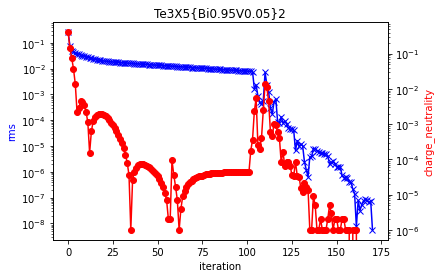

In [31]:
wfd, _ = kkr_scf_wc.get_wf_defaults()
#wfd = Dict(dict= wfd)
wfd['strmix'] = 0.01
wfd['brymix'] = 0.03
wfd['nsteps'] = 200

# use the same convergence settings as in scf of Bi2Te3 with renormalized weights
wfd['convergence_setting_coarse']['kmesh'] = [30, 30, 30]
wfd['convergence_setting_coarse']['n1'] = 5
wfd['convergence_setting_coarse']['n2'] = 29
wfd['convergence_setting_coarse']['n3'] = 7
wfd['convergence_setting_coarse']['npol'] = 7
wfd['convergence_setting_coarse']['tempr'] = 600.0
wfd['convergence_setting_fine'] = wfd['convergence_setting_coarse']
wfd['convergence_criterion'] = 1e-7

# initialize magnetization on impurity sites
wfd['mag_init'] = True
wfd['init_pos'] = [0,0,0,0,0,0,0,0,0,1,0,1]

builder = kkr_scf_wc.get_builder()
builder.metadata.label = 'V:Bi2Te3_CPA'
builder.calc_parameters = Dict(dict=params_cpa)
builder.kkr = kkr_code
builder.options = Dict(dict=options)
builder.startpot_overwrite = startpot_cpa
builder.structure = struc_cpa
builder.voronoi = Code.get_from_string('voro@claix18_init')
builder.wf_parameters = Dict(dict=wfd)

# scf_cpa_wf = submit(builder)
scf_cpa_wf = load_node('5479817a-72ad-4039-8190-a5813c98e433')
plot_kkr(scf_cpa_wf, silent=True)

---

## analyze CPA output (DOS and bandstructure)

In [32]:
# DOS CPA with renormalized weights

builder = dos_ref.get_builder_restart()
builder.remote_data = scf_cpa2.outputs.remote_folder
builder.metadata.label = 'V:Bi2Te3 CPA DOS around EF'
# dos_cpa = submit(builder)
dos_cpa = load_node('cb87a1e1-da66-4d45-8f4a-4d8cce0cc0d0')
dos_cpa.process_status

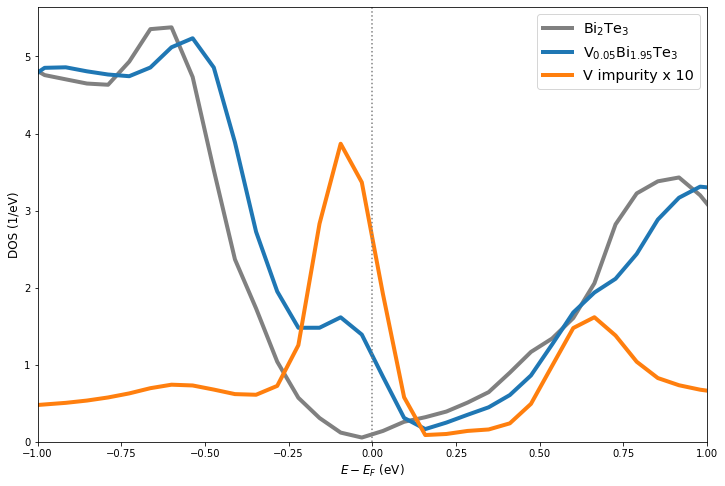

In [33]:
x = dos_cpa.outputs.dos_data_interpol.get_x()[1][0]
y = dos_cpa.outputs.dos_data_interpol.get_y()[0][1]
y = y.reshape(12,2,-1)

plt.figure(figsize=(12,8))

plot_kkr(dos, label='Bi$_2$Te$_3$', color='grey', ls='-', silent=True,
         sum_spins=True, l_channels=False, nofig=True, noshow=True, lw=4)

ytot = 0 * y[0,0]


for i, iatom in enumerate(range(12)):
    weights = {8: 1-conc, 9:conc, 10:1-conc, 11:conc}.get(iatom, 1.)
    ytot -= weights * (y[iatom,0,:] - y[iatom,1,:])

plt.plot(x, ytot, label='V$_{0.05}$Bi$_{1.95}$Te$_3$', color=f'C{0}', lw=4)
plt.plot(x, 0.5*(-y[iatom,0,:] + y[iatom,1,:]), label=f'V impurity x 10', color=f'C{1}', lw=4)
    
# plt.axhline(0, color='grey', ls=':')
#plt.xlim(-3,3)
plt.xlim(-1,1)
plt.ylim(0)
plt.xlabel('$E-E_F$ (eV)', fontsize='large')
plt.ylabel('DOS (1/eV)', fontsize='large')
plt.legend(fontsize='x-large')
plt.title('')
plt.axvline(0, color='grey', ls=':')
plt.show()

In [34]:
# renormalized weights

builder = bs_ref.get_builder_restart()
builder.remote_data = scf_cpa2.outputs.remote_folder
builder.metadata.label = 'V:Bi2Te3 CPA bandstruc around EF'
# bs_cpa = submit(builder)
bs_cpa = load_node('475b6d07-ba81-434b-ba64-b53f9939dcc8')

loading data
loading data


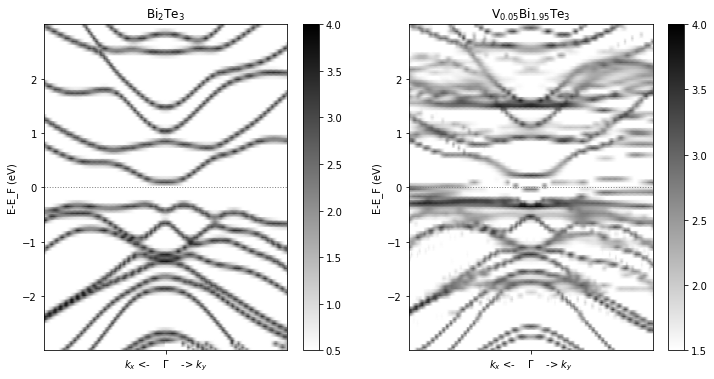

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
c = bs.get_outgoing(node_class=KkrCalculation).first().node
plot_kkr(c, silent=True, noshow=True, nofig=True, cmap='binary')
plt.xticks([100], ['$k_x$ <-    $\Gamma$    -> $k_y$'])
plt.title('Bi$_2$Te$_3$'); plt.xlabel('')
plt.clim(0.5,4)

# ATTENTION: the V contribution is overestimated in this plot since no weighting with the concentration is done here

plt.subplot(1,2,2)
c = bs_cpa.get_outgoing(node_class=KkrCalculation).first().node
plot_kkr(c, silent=True, noshow=True, nofig=True, cmap='binary')
plt.xticks([100], ['$k_x$ <-    $\Gamma$    -> $k_y$'])
plt.title('V$_{0.05}$Bi$_{1.95}$Te$_3$'); plt.xlabel('')
plt.clim(1.5,4)

plt.show()

In [36]:
def load_qdos_cpa(c):

    from tqdm import tqdm
    i = 0
    for qn in tqdm(c.outputs.retrieved.list_object_names()):
        if 'qdos' in qn:
            iatom = int(qn.split('.')[1])
            weight = 1.0
            if iatom in [10, 12]:
                # impurity atoms
                weight = conc
            elif iatom in [9, 11]:
                # Bi atoms
                weight = 1-conc
            else:
                # all the other atoms
                weight = 1.0
            with c.outputs.retrieved.open(qn) as _f:
                tmp = np.loadtxt(_f)
            if i==0:
                d = tmp.copy()
                d_Bi2Te3 = tmp.copy(); d_Bi2Te3[:,4:] = 0
                d_imp = tmp.copy(); d_imp[:,4:] = 0
            else:
                d[:,4:] += tmp[:,4:] * weight

            if weight==1-conc:
                d_Bi2Te3[:,4:] += tmp[:,4:]
            elif weight==conc:
                d_imp[:,4:] += tmp[:,4:]

            i+=1
            
    from masci_tools.io.common_functions import search_string, get_Ry2eV
    with c.outputs.retrieved.open('output.0.txt') as _f:
        txt = _f.readlines()
        itmp = search_string('  Fermi energy', txt)
        ef = float(txt[itmp].split()[-2])

    e = (np.sort(np.array(list(set(d[:,0])))) - ef) * get_Ry2eV()
    Ne = len(e)
    Nk = len(d)//Ne
    d = d.reshape(Ne, Nk, -1)
    d_imp = d_imp.reshape(Ne, Nk, -1)
    d_Bi2Te3 = d_Bi2Te3.reshape(Ne, Nk, -1)
    k = range(Nk)
    
    return e, k, d, d_imp, d_Bi2Te3

In [37]:
e, k, d, d_imp, d_Bi2Te3 = load_qdos_cpa(c)

100%|██████████| 33/33 [00:06<00:00,  4.90it/s]


IndexError: too many indices for array

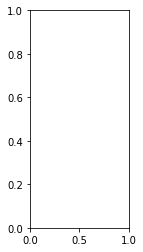

In [44]:
# plot band structure with proper concentration weights

def make_labels(cmin, cmax, title, ylbl = True):
    plt.clim(cmin, cmax)
    if ylbl:
        plt.ylabel('$E-E_F$ (eV)', fontsize='x-large')
    plt.xticks([100], ['$k_x$ <--    $\Gamma$    --> $k_y$'], fontsize='x-large')
    plt.title(title, fontsize='x-large')
    plt.axhline(0, color='grey', ls=':')
    # highlight gap region
    plt.axhline(-0.15, color='grey', ls='--')
    plt.axhline(0.17, color='grey', ls='--')
    
plt.figure(figsize=(16,9))

plt.subplot(1,3,1)
plt.pcolormesh(k, e, (abs(d))[:,:,4], cmap='binary', shading='gouraud')
make_labels(0, 500., 'V:Bi2Te3')

plt.subplot(1,3,2)
plt.pcolormesh(k, e, (abs(d_Bi2Te3))[:,:,4], cmap='Blues', shading='gouraud')
make_labels(0, 200., 'Bi2Te3 host', ylbl= False)

plt.subplot(1,3,3)
plt.pcolormesh(k, e, (abs(d_imp))[:,:,4], cmap='Reds', shading='gouraud')
# plt.colorbar()
make_labels(0, 600., 'V impurity', ylbl= False)

plt.tight_layout()

plt.show()

---

## Calculate Jijs from CPA with the host code

In [39]:
scf_remote = scf_cpa_wf.outputs.last_RemoteData
last_calc = scf_remote.get_incoming(node_class=KkrCalculation).first().node

builder = last_calc.get_builder_restart()
builder.parent_folder = scf_remote

# set Jij parameters
para_Jij = {k:v for k,v in scf_cpa_wf.outputs.last_InputParameters.get_dict().items() if v}
para_Jij['TEMPR'] = 400.0 # slightly reduce temperature
para_Jij['RCLUSTZ'] = 1.8 # increase cluster radius
para_Jij['BZDIVIDE'] = [120, 120, 120] # increase k-points
para_Jij['NSTEPS'] = 1 # one-shot
para_Jij['NATOMIMPD'] = 500 # array dimension
para_Jij['NSHELD'] = 2000 # array dimension
para_Jij['KPOIBZ'] = 120**3 # array dimension
# add 'XCPL' runopt to list of runopts (activates Jij calculation)
runopts = para_Jij.get('RUNOPT', [])
runopts.append('XCPL    ')
para_Jij['RUNOPT'] = runopts
# set Jij parameters
# i and j index for Jij calculation in internal units
# uses site index (i.e. needs to be <=10)
para_Jij['JIJSITEI'] = [1, 9] # imp position 1 only
para_Jij['JIJSITEJ'] = [2, 9, 10] # imp position 1 and 2
para_Jij['JIJRAD'] = 5.0 # radius in lattice constants up to which the Jijs are calculated

builder.parameters = Dict(dict=para_Jij)

# starting angles for 3 directions, needed to extract full Jij tensor

Nsites = 12

init_angles_x = Dict(dict={
    'fix_dir': [True for i in range(Nsites)],
    'theta': [90.0 for i in range(Nsites)],
    'phi': [0.0 for i in range(Nsites)],
})

init_angles_y = Dict(dict={
    'fix_dir': [True for i in range(Nsites)],
    'theta': [90.0 for i in range(Nsites)],
    'phi': [90.0 for i in range(Nsites)],
})

init_angles_z = Dict(dict={
    'fix_dir': [True for i in range(Nsites)],
    'theta': [0.0 for i in range(Nsites)],
    'phi': [0.0 for i in range(Nsites)],
})


# submit m||z calculation
builder.initial_noco_angles = init_angles_z
builder.metadata.label = 'V:Bi2Te3_Jij_z'
# calc_Jij_z = submit(builder)
calc_Jij_z0 = load_node('378a0960-7743-45f6-9b93-b9293e6d6cff') # smaller k-mesh
calc_Jij_z = load_node('2bd0b0b1-77ab-47c9-afc3-7fa48589ff1d')

builder.initial_noco_angles = init_angles_y
builder.metadata.label = 'V:Bi2Te3_Jij_y'
# calc_Jij_y = submit(builder)
calc_Jij_y0 = load_node('0423e71f-d098-4ed5-a62c-89174984c786') # smaller k-mesh
calc_Jij_y = load_node('54cda62c-2995-4537-8aee-0b08f6a2afa3')

builder.initial_noco_angles = init_angles_x
builder.metadata.label = 'V:Bi2Te3_Jij_x'
# calc_Jij_x = submit(builder)
calc_Jij_x0 = load_node('6a6d8159-5f03-458a-867a-ededf8f3cd7a') # smaller k-mesh
calc_Jij_x = load_node('a6429605-bc4f-48e5-95e4-107e308e39e6')

calc_Jij_z, calc_Jij_y, calc_Jij_x

(<CalcJobNode: uuid: 2bd0b0b1-77ab-47c9-afc3-7fa48589ff1d (pk: 104990) (aiida.calculations:kkr.kkr)>,
 <CalcJobNode: uuid: 54cda62c-2995-4537-8aee-0b08f6a2afa3 (pk: 104994) (aiida.calculations:kkr.kkr)>,
 <CalcJobNode: uuid: a6429605-bc4f-48e5-95e4-107e308e39e6 (pk: 104993) (aiida.calculations:kkr.kkr)>)

### parse Jij output and plot

In [40]:
# parsing jij output

import numpy as np    
from masci_tools.io.common_functions import search_string, get_aBohr2Ang, get_Ry2eV
from aiida.orm import ArrayData, StructureData
from aiida.engine import calcfunction
from aiida_kkr.calculations import KkrCalculation
from aiida_kkr.tools import find_parent_structure

def get_jijs_shells(jij_calc, verbose=False):
    """read the jij.atom files from the retrieved and determine if the file has DMI or not"""

    # read the jij.atom files
    jijs_shells = []
    for jijfile in [i for i in jij_calc.outputs.retrieved.list_object_names() if 'Jij' in i]:
        i_index = int(jijfile.split('.atom')[1])
        if verbose:
            print('load jij.atom', i_index)
        with jij_calc.outputs.retrieved.open(jijfile) as f:
            tmp = np.loadtxt(f)
        # sort by radius
        jij_atom = tmp[tmp[:,0].argsort()]
        if len(jij_atom)>4:
            # add i index, needed for mapping to spirit data
            jij_atom[:, -1] = i_index
        jijs_shells += list(jij_atom)
    jijs_shells = np.array(jijs_shells)
    if verbose:
        print('jijs_shells.shape', jijs_shells.shape)
    jijs_shells = jijs_shells[jijs_shells[:,0].argsort()]

    # format of jijs_shells differs in old and new solver:
    if len(jijs_shells[0])==4:
        # - isotropic exchange constants only (old solver). The columns refer to:
        #   * [0] |Rij| in units of the lattice constant
        #   * [1] Jij in Ryd
        #   * [2] shell-number
        #   * [3] atom type of atom j
        #   * [4] atom type of atom i
        dmimode = False
    else:
        # - full exchange tensor (new solver). The columns refer to:
        #   * [0] ∣Rij∣ in units of the lattice constant
        #   * [1] Jij (isotropic part) in Ryd
        #   * [2] Dij (anti-symmetric DMI part) in Ryd
        #   * [3] Sij (diagonal traceless part) in Ryd
        #   * [4] Aij (off-diagonal symmetric part) in Ryd
        #   * [5-7] R⃗j − R⃗i (3 component vector)
        #   * [8] atom type of atom j
        #   * [9] atom type of atom i
        dmimode = True

    return jijs_shells, dmimode


def expand_jijs_iso(jijs_shells, shells, cell, alat):
    """expand jijs from shells to all pairs which is easier to use in spirit
    This is the roune that deals with isotropic interactions (i.e. using the old solver)"""
    jijs_expanded, positions_expanded = [], []
    for i, j in enumerate(jijs_shells):
        for s in shell[int(j[3]-1)]:
            x, y, z = alat*s[7], alat*s[8], alat*s[9]
            # maybe anoffset to position of this site still needed?!
            
            # calculate da, db, dc ( i.e. the mutiplicities of the unit vectors)
            da, db, dc = np.array(np.round(np.matrix(cell)**-1*np.matrix([x, y, z]).transpose()).transpose(), dtype=int).reshape(-1)
            #                       i,      j,    da, db, dc,   Jij (meV)
            jijs_expanded.append([s[1]-1, s[2]-1, da, db, dc, j[1]*get_Ry2eV()*1000])
            positions_expanded.append([x, y, z])
    # convert to numpy array
    jijs_expanded = np.array(jijs_expanded)
    positions_expanded = np.array(positions_expanded)

    return jijs_expanded, positions_expanded


def expand_jijs_dmi(jijs_shells_x, jijs_shells_y, jijs_shells_z, shells, cell, sites, alat):
    """Bring output Jijs of the new solver into the right form
    (KKR output already is expanded in shells but it needs to be brought into the right form
    by combining the x,y,z calculations and the Rvec information)
    This will give the full Jij tensor and prodiuce the columns that spirit can understand
    """

    # conversion factor from Ry to meV
    Ry2meV = 1000*get_Ry2eV()

    jijs_expanded, positions_expanded = [], []
    for ipos, jz in enumerate(jijs_shells_z):
        # also load the information from m||x and m||y
        jx = jijs_shells_x[ipos]
        jy = jijs_shells_y[ipos]
        # get i and j indices of the atoms
        iatom = int(jz[-1])
        jatom = int(jz[-2])
        
        # Rvec = pos_[i] + R_ij[j], with R_ij[j] given in the Jij.atom files (in alat units)
        dx = alat*jz[5]
        dy = alat*jz[6]
        dz = alat*jz[7]
        x = sites[iatom].position[0] + dx
        y = sites[iatom].position[1] + dy
        z = sites[iatom].position[2] + dz
        # calculate da, db, dc ( i.e. the mutiplicities of the unit vectors)
        da, db, dc = np.array(np.round(np.matrix(cell)**-1*np.matrix([x, y, z]).transpose()).transpose(), dtype=int).reshape(-1)

        #collect full Jij tensor
        # 1: J, 2: D, 3: S, 4: A
        Jxx = (jz[1]+jz[3]+jy[1]+jy[3])/2. * Ry2meV
        Jxy = jz[4] * Ry2meV
        Jxz = jy[4] * Ry2meV
        Jyx = jz[4] * Ry2meV
        Jyy = (jz[1]-jz[3]+jx[1]+jx[3])/2. * Ry2meV
        Jyz = jx[4] * Ry2meV
        Jzx = jy[4] * Ry2meV
        Jzy = jx[4] * Ry2meV
        Jzz = (jx[1]-jx[3]+jy[1]-jy[3])/2. * Ry2meV
        # calculate DMI vector
        Dx =  jx[2] * Ry2meV
        Dy = -jy[2] * Ry2meV
        Dz =  jz[2] * Ry2meV
        
        # collect data in big arrays
        #                       i,     j,   da, db, dc,   Jij (meV),  Dij vector(meV),     full Jij tensor (meV)
        jijs_expanded.append([iatom, jatom, da, db, dc, (Jxx+Jyy+Jzz)/3., Dx, Dy, Dz, Jxx, Jxy, Jxz, Jyx, Jyy, Jyz, Jzx, Jzy, Jzz])
        positions_expanded.append([dx, dy, dz])
        
    # convert collected data to numpy array
    jijs_expanded = np.array(jijs_expanded)
    positions_expanded = np.array(positions_expanded)

    return jijs_expanded, positions_expanded


def get_sites(structure):
    """Get all sites also for a CPA structure"""
    sites = []  # for CPA
    for site in structure.sites:
        sitekind = structure.get_kind(site.kind_name)
        for ikind in range(len(sitekind.symbols)):
            sites.append(site)
    return sites


# @calcfunction
def parse_jij_calc(jij_calc_retrieved, jij_calc_x_retrieved=None, jij_calc_y_retrieved=None, verbose=False):
    """
    Parse the output of a Jij calculation from the retreived folder of a KkrCalculation
    
    :params jij_calc_retrieved: retrieved folder output of a KkrCalculation which ran with the Jij inputs (m||z is assumed)
    :params jij_calc_x_retrieved: like jij_calc_retrieved but for m||x (only needed for new solver)
    :params jij_calc_y_retrieved: like jij_calc_retrieved but for m||y (only needed for new solver)
    :params verbose: True/False can be used to print debugging output
    
    :returns:
      {'jij_data': jij_data, 'structure_jij_sites': struc_jij_sites}
      where
      * jij_data is and ArrayData that contains the expanded Jij's (see 'array_descriptions' extra for more details)
      * struc_jij_sites is the reduced structure that contains onlt the atoms which have Jij couplings
        (comes from the input of the KkrCalculation). The mappings to the original structure (and their i,j indices) is given as an extra
    """

    # extract kkrCalculation from retreived child
    jij_calc = jij_calc_retrieved.get_incoming(node_class=KkrCalculation).first().node
    if verbose:
        print('jij(z) calculation:', jij_calc.uuid)

    # extract basis vectors ot the structure, needed to convert from cartesian coordinates (x,y,z)
    # to relative coordinates (da, db, dc) such that (x, y, z)^T = da*a + db*b + dc*c
    # with a,b,c being the three unit vectors
    structure = find_parent_structure(jij_calc)
    cell = np.array(structure.cell)
    natyp = len(get_sites(structure))
    if verbose:
        print('found structure with natyp:', natyp)

    # in KKR everything is scaled with the lattice constant
    alat = jij_calc.outputs.output_parameters['alat_internal'] * get_aBohr2Ang()

    # read jij.atom files
    jijs_shells_z, dmimode = get_jijs_shells(jij_calc, verbose)
    
    # read jij.atom files if a calculation in x and y are given in the input
    dmimode_x, dmimode_y = False, False
    if dmimode and jij_calc_x_retrieved is not None:
        jij_calc_x = jij_calc_x_retrieved.get_incoming(node_class=KkrCalculation).first().node
        if verbose:
            print('jij(x) calculation:', jij_calc_x.uuid)
        jijs_shells_x, dmimode_x = get_jijs_shells(jij_calc_x)
        if not dmimode_x:
            raise ValueError('jij_calc_x is not a DMI calculation (i.e. used old solver)')
    if dmimode and jij_calc_y_retrieved is not None:
        jij_calc_y = jij_calc_y_retrieved.get_incoming(node_class=KkrCalculation).first().node
        if verbose:
            print('jij(y) calculation:', jij_calc_y.uuid)
        jijs_shells_y, dmimode_y = get_jijs_shells(jij_calc_y)
        if not dmimode_y:
            raise ValueError('jij_calc_y is not a DMI calculation (i.e. used old solver)')
    # consistency check
    if dmimode and not (dmimode_x and dmimode_y):
        raise ValueError('Found dmimode but not all calculations (x,y and z) were given correctly')


    # read the shells information that is needed to map to the complete list of pairs
    with jij_calc.outputs.retrieved.open('shells.dat') as f:
        txt = f.readlines()
    nshell = int(txt.pop(0).split()[0])
    ioffset = 0
    shells = []
    for ishell in range(nshell):
        nat = int(txt[ioffset].split()[1])
        shell = []
        for iline in range(nat):
            shell.append(txt[ioffset+1+iline].split())
        shells.append(np.array(shell, dtype=float))
        ioffset += 1 + nat
    # take only the shells which are not on-site
#     if verbose:
#         print('found shells:', shells)

    # expand shells data to a structure that spirit can understand (i.e. take all pairs)
    if not dmimode:
        if verbose:
            print('expand isotropic Jijs')
        jijs_expanded, positions_expanded = expand_jijs_iso(jijs_shells_z, shells, cell, alat)
    else:
        if verbose:
            print('expand anisotropic Jijs, Dij etc')
        jijs_expanded, positions_expanded = expand_jijs_dmi(jijs_shells_x, jijs_shells_y, jijs_shells_z, shells, cell, get_sites(structure), alat)

    # create an auxiliary structure that contains only the sites which are used in the Jij step
    # (i.e. we drop all sites where we don't have couplings)
    struc_jij_sites = StructureData(cell=cell)
    struc_jij_sites.pbc = structure.pbc
    all_sites_jij = set(list(jijs_expanded[:,0])+list(jijs_expanded[:,1]))
    isite, icount, mappings = 0, 0, [] # for mapping to the sites of the reduced structure
    for site in structure.sites:
        sitekind = structure.get_kind(site.kind_name)
        for ikind, symbol in enumerate(sitekind.symbols):
            isite += 1
            # take only structues for which Jij couplings are extracted
            if isite in all_sites_jij:
                mappings.append([icount, isite])
                icount += 1
                if ikind==0:
                    struc_jij_sites.append_atom(
                        position=site.position,
                        symbols=sitekind.symbols,
                        weights=sitekind.weights
                    )
    if verbose:
        print(f'reduced structure has {len(struc_jij_sites.sites)} sites')

    # now collect the outputs in AiiDA Array objects
    jij_data = ArrayData()
    jij_data.set_array('Jij_shells', jijs_shells_z)
    if dmimode:
        # also add x and y shells output
        jij_data.set_array('Jij_shells_x', jijs_shells_x)
        jij_data.set_array('Jij_shells_y', jijs_shells_y)
    jij_data.set_array('Jij_expanded', jijs_expanded)
    jij_data.set_array('positions_expanded', positions_expanded)
    # add description to extras
    jij_data.extras['array_descriptions'] = {
        'Jij_shells': """Jij output in the shells that KKR found.
    The format differs for the type of calculation:
    - isotropic exchange constants only (old solver). The columns refer to:
      * [0] |Rij| in units of the lattice constant
      * [1] Jij in Ryd
      * [2] shell-number
      * [3] atom type of atom j
    - full exchange tensor (new solver). The columns refer to:
      * [0] ∣Rij∣ in units of the lattice constant
      * [1] Jij (isotropic part) in Ryd
      * [2] Dij (anti-symmetric DMI part) in Ryd
      * [3] Sij (diagonal traceless part) in Ryd
      * [4] Aij (off-diagonal symmetric part) in Ryd
      * [5-7] Rj - Ri (3 component vector)
      * [8] atom type of atom j

    if the full exchange tensor is calculated the Jij_shells_x and Jij_shells_y also exist""",
        'Jij_expanded': 'i, j, da, db, dc, Jij (meV) [, Dij vector (x, y, z in meV), full Jij tensor (xx, xy, xz, yx, yy, yz, zx, zy, zz in meV)]',
        'positions_expanded': 'x, y, z (Ang.) positions of all pairs in Jij_expanded',
    }

    # add extras to generated structure for quick access
    struc_jij_sites.extras['mappings_ij'] = mappings
    struc_jij_sites.extras['uuid_struc_orig'] = structure.uuid
    struc_jij_sites.extras['uuid_jij_data'] = jij_data.uuid
    
    # return dict (link_label: node)
    return {'jij_data': jij_data, 'structure_jij_sites': struc_jij_sites}


def get_jij_data_for_plotting(calc_Jij_x, calc_Jij_y, calc_Jij_z):
    """parse Jij calculations and extract Jij tensor elements"""

    jij_output = parse_jij_calc(
        calc_Jij_z.outputs.retrieved,
        jij_calc_x_retrieved=calc_Jij_x.outputs.retrieved,
        jij_calc_y_retrieved=calc_Jij_y.outputs.retrieved,
        verbose=False
    )
    jij_tensor = jij_output['jij_data']

    pos = jij_tensor.get_array('positions_expanded')
    jijs = jij_tensor.get_array('Jij_expanded')

    # throw away Bi atoms and use only impurty atoms (i.e. i,j in [10, 12])
    pos = pos[jijs[:,0]==10]
    jijs = jijs[jijs[:,0]==10]
    # j
    pos = pos[jijs[:,1]%2==0]
    jijs = jijs[jijs[:,1]%2==0]

    # factor 2 for consistency with impurity code
    jijs[:,5:] *= 2.0

    return pos, jijs

In [41]:
# parse Jij data
pos, jijs = get_jij_data_for_plotting(calc_Jij_x, calc_Jij_y, calc_Jij_z)

# for comparison to smaller k-mesh (convergence test)
pos0, jijs0 = get_jij_data_for_plotting(calc_Jij_x0, calc_Jij_y0, calc_Jij_z0)

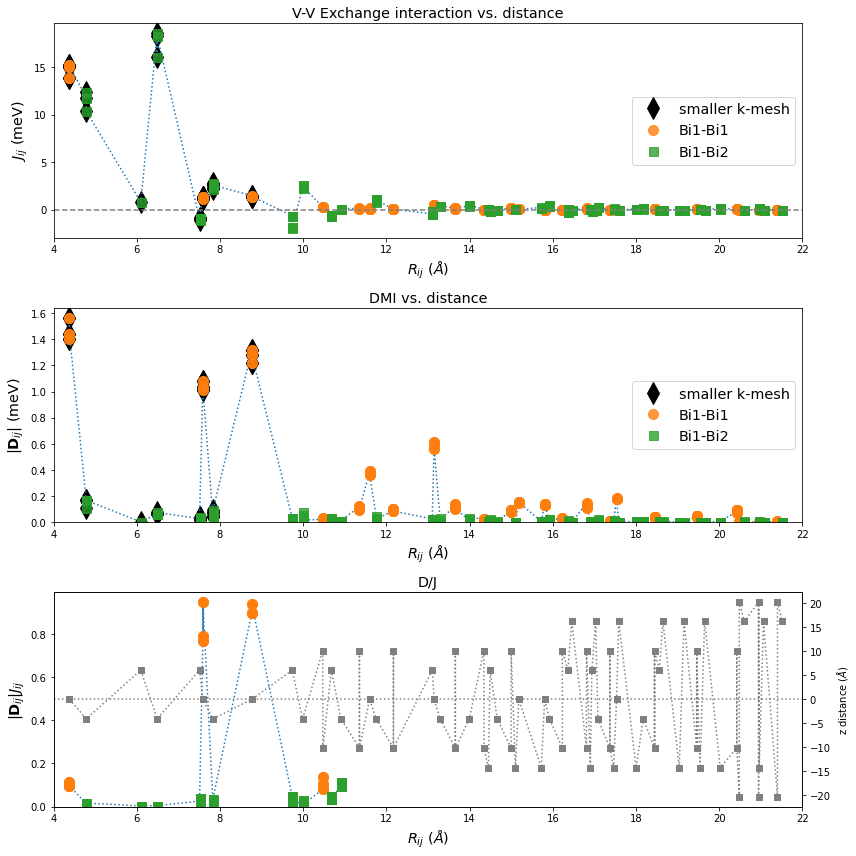

In [42]:
plt.figure(figsize=(12,12))

# plt.subplot(2,1,1)
plt.subplot(3,1,1)
plt.title('V-V Exchange interaction vs. distance', fontsize='x-large')
r0 = np.sqrt(np.sum(pos0**2, axis=1))
plt.plot(r0, jijs0[:,5], 'kd', ms=15, label='smaller k-mesh')
r = np.sqrt(np.sum(pos**2, axis=1))
plt.plot(r, jijs[:,5], ':')
plt.plot(r[jijs[:,1]==10], jijs[jijs[:,1]==10][:,5], 'o', ms=10, alpha=0.8, label='Bi1-Bi1')
plt.plot(r[jijs[:,1]==12], jijs[jijs[:,1]==12][:,5], 's', ms=9, alpha=0.8, label='Bi1-Bi2')
plt.ylabel('$J_{ij}$ (meV)', fontsize='x-large')
plt.axhline(0, ls='--', color='grey')
plt.xlabel('$R_{ij}$ ($\AA$)', fontsize='x-large')
plt.xlim(4, 22)

plt.legend(fontsize='x-large', loc=5)

plt.subplot(3,1,2)
plt.title('DMI vs. distance', fontsize='x-large')
d0 = np.sqrt(np.sum(jijs0[:,6:9]**2, axis=1))
plt.plot(r0, d0, 'kd', ms=15, label='smaller k-mesh')
d = np.sqrt(np.sum(jijs[:,6:9]**2, axis=1))
plt.plot(r, d, ':')
plt.plot(r[jijs[:,1]==10], d[jijs[:,1]==10], 'o', ms=10, alpha=0.8, label='Bi1-Bi1')
plt.plot(r[jijs[:,1]==12], d[jijs[:,1]==12], 's', ms=9, alpha=0.8, label='Bi1-Bi2')
plt.ylabel('$|\mathbf{D}_{ij}|$ (meV)', fontsize='x-large')
plt.xlabel('$R_{ij}$ ($\AA$)', fontsize='x-large')
plt.ylim(0)
plt.xlim(4, 22)

plt.legend(fontsize='x-large', loc=5)

plt.subplot(3,1,3)
plt.title('D/J', fontsize='x-large')
mask = np.where(r<=11)
rr, dd, jj = r[mask], d[mask], jijs[mask]
plt.plot(rr, abs(dd/jj[:,5]), ':')
plt.plot(rr[jj[:,1]==10], abs(dd/jj[:,5])[jj[:,1]==10], 'o', ms=10, label='Bi1-Bi1')
plt.plot(rr[jj[:,1]==12], abs(dd/jj[:,5])[jj[:,1]==12], 's', ms=9, label='Bi1-Bi2')
plt.ylabel('$|\mathbf{D}_{ij}|J_{ij}$', fontsize='x-large')
plt.xlabel('$R_{ij}$ ($\AA$)', fontsize='x-large')
plt.ylim(0)
plt.xlim(4, 22)

# plt.legend(fontsize='x-large', loc=5)

plt.twinx()
plt.plot(r, (pos[:,2]), 's:', color='grey')
plt.axhline(0, ls=':', color='grey')
plt.ylabel('z distance ($\AA$)')

plt.tight_layout()

plt.show()

In [43]:
print('moments (mu_B): Te1, Te2, Bi, V-imp')
print(np.array(scf_cpa_wf.outputs.last_calc_out['magnetism_group']['spin_moment_per_atom'])[[0,1,-2,-1]])

moments (mu_B): Te1, Te2, Bi, V-imp
[-1.2000e-02 -1.4600e-02  2.2000e-03  2.4339e+00]
